# Import Libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  sample_data/


In [7]:
os.chdir('drive')
os.chdir('MyDrive')
os.chdir("Colab Notebooks")
os.chdir("Music Genre Classification")

In [8]:
df=pd.read_csv('train_data.csv')
df_t=pd.read_csv('test_data.csv')
print(df_t.head())
df.head()

   centroid_max  centroid_min  centroid_mean  ...  mfcc_19_skew       tempo  label
0   5820.641540    261.040213    1489.099451  ...     -0.106458  143.554688      0
1   4162.982445    222.777126     910.093663  ...     -0.160989  123.046875      0
2   5473.726906    201.631743     846.608476  ...     -0.291725   83.354335      0
3   4152.928614    228.475668     533.912001  ...     -0.832391  143.554688      0
4   4100.772671    258.071118    1172.629536  ...     -0.045674  103.359375      0

[5 rows x 170 columns]


,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,flux_max,flux_min,flux_mean,flux_std,flux_kurtosis,flux_skew,rmse_max,rmse_min,rmse_mean,rmse_std,rmse_kurtosis,rmse_skew,zcr_max,zcr_min,zcr_mean,zcr_std,zcr_kurtosis,zcr_skew,contrast_max,contrast_min,contrast_mean,contrast_std,contrast_kurtosis,contrast_skew,bandwidth_max,bandwidth_min,bandwidth_mean,bandwidth_std,bandwidth_kurtosis,bandwidth_skew,flatness_max,flatness_min,flatness_mean,flatness_std,...,mfcc_13_kurtosis,mfcc_13_skew,mfcc_14_max,mfcc_14_min,mfcc_14_mean,mfcc_14_std,mfcc_14_kurtosis,mfcc_14_skew,mfcc_15_max,mfcc_15_min,mfcc_15_mean,mfcc_15_std,mfcc_15_kurtosis,mfcc_15_skew,mfcc_16_max,mfcc_16_min,mfcc_16_mean,mfcc_16_std,mfcc_16_kurtosis,mfcc_16_skew,mfcc_17_max,mfcc_17_min,mfcc_17_mean,mfcc_17_std,mfcc_17_kurtosis,mfcc_17_skew,mfcc_18_max,mfcc_18_min,mfcc_18_mean,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo,label
0,4053.985673,925.934083,1727.645355,376.901924,6.096711,1.660034,10.981944,0.0,1.391008,1.481524,5.030481,2.113917,0.364873,0.020546,0.127812,0.058704,0.096485,0.618513,0.299805,0.026367,0.083077,0.031171,5.937552,1.683604,48.289165,4.028252,20.530733,8.761009,1.002488,1.393933,3271.509734,1289.209726,1965.963122,301.968349,0.636158,0.380976,0.092950,0.000337,0.004742,0.006531,...,0.324278,-0.043230,22.975828,-29.134670,-5.073298,7.991895,0.058589,0.121894,31.619713,-22.741468,0.689541,8.218079,-0.101717,0.033028,19.711369,-21.860304,-1.781526,6.976332,-0.139180,0.028247,24.342232,-24.535332,-0.403263,7.473668,0.218530,0.288626,32.663315,-29.407766,-2.322567,8.289201,0.954234,0.303920,34.931171,-25.915401,1.033782,7.581626,0.408693,0.241352,123.046875,0
1,5430.122461,372.728961,1450.533158,615.185827,4.766277,1.475144,17.791128,0.0,1.444008,1.996799,12.743418,3.142622,0.295631,0.003667,0.093895,0.052508,0.107289,0.483677,0.397461,0.004883,0.056034,0.041543,13.978252,2.855463,48.775996,5.534489,20.676334,8.239387,1.531287,1.428818,3311.542052,866.567872,1971.951481,477.540669,-0.412464,0.082167,0.061910,0.000026,0.002365,0.005163,...,-0.154448,0.014576,19.489361,-28.896770,-6.586596,8.143734,-0.258853,0.081670,30.067501,-35.091881,-0.017758,8.305912,0.348345,0.046045,26.885567,-29.229404,-1.051929,8.508726,-0.028970,0.069121,30.985367,-22.316357,0.102890,7.884105,0.151258,0.302733,36.023636,-26.260275,0.009591,8.132369,1.002932,0.247480,31.484390,-20.805553,0.305457,7.547182,0.618586,0.401443,107.666016,0
2,4709.894987,356.735645,1493.679993,419.421447,11.343314,1.900807,14.719387,0.0,1.638258,1.950674,8.131659,2.490638,0.356653,0.020144,0.173272,0.059576,-0.505644,0.205437,0.450195,0.006836,0.076301,0.035163,34.933216,3.990200,67.980056,4.558865,22.197265,8.727204,0.133514,0.939986,2657.716271,866.915691,1698.458862,306.525382,0.010474,0.188831,0.040072,0.000027,0.002646,0.003681,...,0.555943,-0.556250,14.690028,-30.254753,-8.156289,7.164390,0.096186,0.234466,26.044487,-18.325630,2.704525,7.283119,-0.031362,0.036540,19.362532,-27.922878,-7.564406,7.873479,0.301123,0.415286,27.384363,-30.106182,-1.644040,8.278567,0.600022,0.149538,23.790066,-21.885801,-3.407319,7.640779,0.347786,0.555627,19.085350,-29.447054,-2.110433,6.445112,0.502269,-0.048041,161.499023,0
3,3692.033659,261.951363,996.753301,428.061426,2.700672,1.111419,14.619913,0.0,1.247379,1.750351,12.675191,3.203631,0.402478,0.008337,0.139123,0.083182,-0.299156,0.608609,0.195312,0.005859,0.033303,0.022579,6.091785,1.633060,53.952526,5.438508,21.428764,7.962859,-0.023194,0.871523,3179.641246,616.064868,1524.055799,420.843059,0.067317,0.566315,0.042672,0.000006,0.001032,0.002106,...,0.765126,-0.489957,42.755226,-31.784576,-1.096431,8.276091,1.949041,0.304608,31.364437,-21.422300,2.693567,7.647832,0.449647,0.232647,24.456470,-33.834549,-1.809412,8.439472,0.218599,-0.330994,20.924242,-19.914608,2.139717,6.757496,0.154365,-0.183636,22.706066,-25.204784,0.850584,7.169938,0.096114,-0.0

In [9]:
X_train=df.drop('label',axis=1).values
y_train=df['label'].values
print(X_train.shape)
print(y_train.shape)
X_test=df_t.drop('label',axis=1).values
y_test=df_t['label'].values
print(X_test.shape)
print(y_test.shape)

(900, 169)
(900,)
(100, 169)
(100,)


## Xtreme Gradient Boost (XGBoost)

In [13]:
params = {
    "cls__max_depth": [4, 6, 10, 20],
    'cls__booster':['gbtree','dart']
}

pipe_xbg = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=0.1)),
    ('cls', XGBClassifier(objective='multi:softmax',num_class=10,verbosity=1))
])

grid_xgb = GridSearchCV(pipe_xbg, params, scoring='accuracy', n_jobs=-1, cv=3)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.1)),
                                       ('cls',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                              

In [14]:
preds1 = grid_xgb.predict(X_test)
print("Best score on validation set (accuracy) = {:.4f}".format(grid_xgb.best_score_))
print("Best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds1)))



Best score on validation set (accuracy) = 0.5400
Best score on test set (accuracy) = 0.6500


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30,fontweight="bold")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20,fontweight="bold")
    plt.xlabel('Predicted label',fontsize=20,fontweight="bold")

Normalized confusion matrix


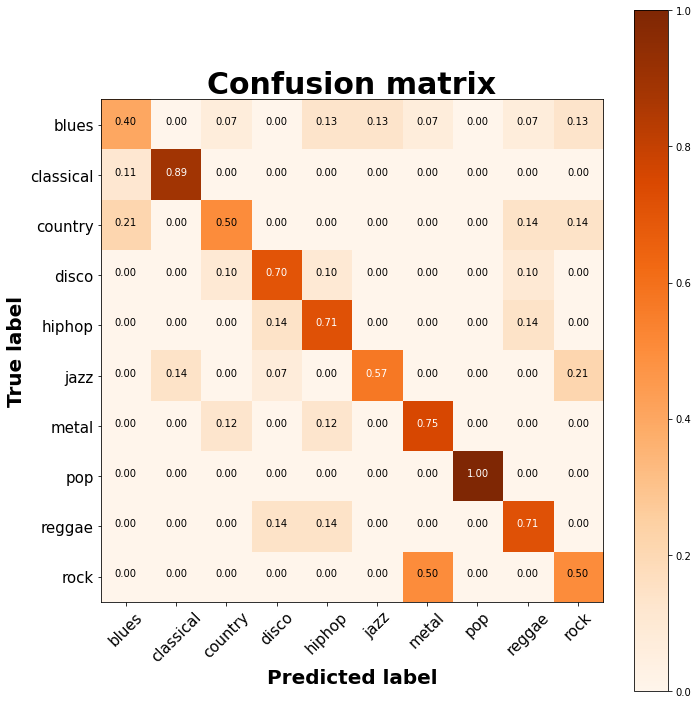

In [16]:
from collections import OrderedDict
import itertools

cm = confusion_matrix(preds1, y_test)
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Deep Neural Network (DNN)

In [17]:
import keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense,Dropout,Input
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.models import Model
from keras.activations import relu
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

In [18]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
input_shape=X_train.shape[1]
y_train_nn=to_categorical(y_train,10,'int')
y_train_nn[:100]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0,

In [19]:
hist = History()
print(X_train.shape)

(900, 169)


In [20]:
inp=Input(shape=(input_shape,))
model = Dense(500,activation='relu')(inp)
model = Dense(1000,activation='relu')(model)
model = Dense(2000,activation='relu')(model)
model = Dense(1000,activation='relu')(model)
model = Dense(500,activation='relu')(model)
model = Dense(100,activation='relu')(model)
model = Dense(10,activation='softmax')(model)

model = Model(inputs=inp,outputs=model)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1)
es=EarlyStopping(monitor='val_loss',patience=20,verbose=1)

In [21]:
model.fit(X_train, y_train_nn, epochs = 120)

Epoch 1/120
29/29 [==============================] - 15s 57ms/step - loss: 1.8550 - accuracy: 0.3330
Epoch 2/120
29/29 [==============================] - 2s 57ms/step - loss: 0.9011 - accuracy: 0.6753
Epoch 3/120
29/29 [==============================] - 2s 57ms/step - loss: 0.7875 - accuracy: 0.7680
Epoch 4/120
29/29 [==============================] - 2s 57ms/step - loss: 0.3685 - accuracy: 0.8791
Epoch 5/120
29/29 [==============================] - 2s 57ms/step - loss: 0.2343 - accuracy: 0.9153
Epoch 6/120
29/29 [==============================] - 2s 56ms/step - loss: 0.2359 - accuracy: 0.9306
Epoch 7/120
29/29 [==============================] - 2s 58ms/step - loss: 0.2131 - accuracy: 0.9350
Epoch 8/120
29/29 [==============================] - 2s 57ms/step - loss: 0.3584 - accuracy: 0.8985
Epoch 9/120
29/29 [==============================] - 2s 58ms/step - loss: 0.0998 - accuracy: 0.9733
Epoch 10/120
29/29 [==============================] - 2s 57ms/step - loss: 0.1634 - accuracy: 0.964

In [22]:
def some_function(x):
  y = np.zeros(x.shape[0]).astype(int)
  print(x.shape[0])
  for i in range(x.shape[0]):
    max=0
    count = -1
    for j in range(x.shape[1]):
      if x[i][j] > max:
        max = x[i][j]
        count = j;
    y[i]=int(count)
  return y

y_pred =  model.predict(X_test)
print(y_pred.shape)
y_pred = some_function(y_pred)
print(y_test[:100])
print(y_pred[:100])

print(accuracy_score(y_pred,y_test))


(100, 10)
100
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
[0 8 0 1 0 0 0 0 0 5 1 1 1 1 1 1 1 1 1 1 2 2 6 2 0 0 9 9 0 9 3 7 3 3 3 4 3
 3 3 3 4 4 4 4 4 6 4 4 4 4 5 5 5 2 5 5 5 5 5 5 9 9 9 6 6 6 4 9 3 4 7 7 7 7
 7 7 7 7 7 7 4 8 8 7 2 2 8 8 8 6 0 6 9 9 9 2 9 6 8 6]
0.68


Normalized confusion matrix


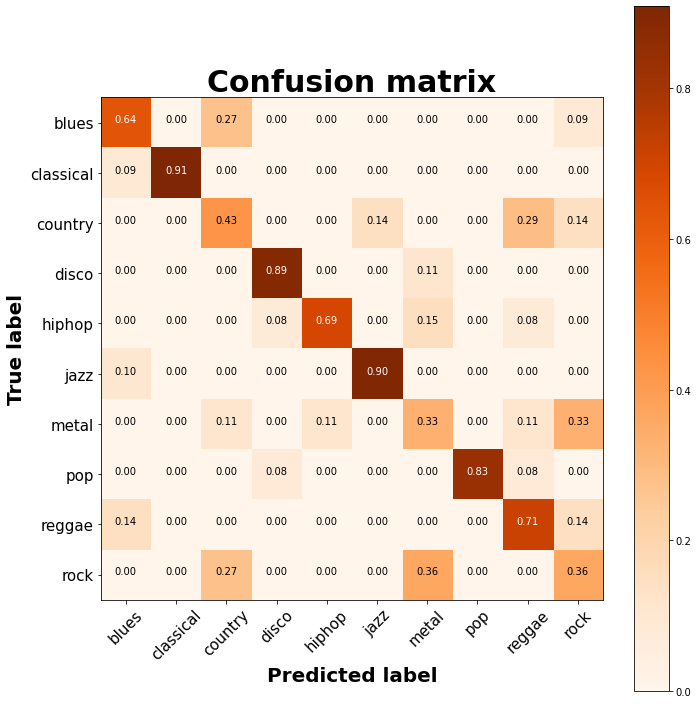

In [26]:
cm = confusion_matrix(y_pred,y_test)
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)